<a href="https://colab.research.google.com/github/aalhayali/MONAI_image_segmentation/blob/main/Image_Segmentation_MRloc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try: 
    import nibabel as nib
except:
    !pip install --quiet nibabel
    import nibabel as nib

try: 
    import monai
except:
    !pip install --quiet monai
    import monai

import torch
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, 
    ToTensord, Spacingd, ScaleIntensityRanged,
    CropForegroundd, Resized, RandAffined,
    RandRotated, RandGaussianNoised

)
from monai.data import Dataset, DataLoader, decollate_batch, pad_list_data_collate
from monai.utils import first
from monai.networks.nets import UNETR, UNet
from monai.networks.layers import Norm
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
import matplotlib.pyplot as plt
import numpy as np
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Image loading

In [ ]:
from glob import glob
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from pathlib import Path
import re

#write a function to sort file names
file_pattern = re.compile(r'.*?(\d+).*?')
def get_order(file):
    match = file_pattern.match(Path(file).name)
    if not match:
        return math.inf
    return int(match.groups()[0])

IMAGES = '/content/drive/MyDrive/Projects/MR-loc Segmentation/Data/Images/*.nii'
IMAGE_LIST = sorted(glob(IMAGES), key=get_order)
# print(IMAGE_LIST)
LABELS = '/content/drive/MyDrive/Projects/MR-loc Segmentation/Data/Labels/*.nii'
LABEL_LIST = sorted(glob(LABELS), key=get_order)
# print(LABEL_LIST)


#Split images and labels into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(IMAGE_LIST, LABEL_LIST, test_size = 0.2)

# print(sorted(X_train, key=get_order))
# print(sorted(y_train, key=get_order))
# print(sorted(X_test, key=get_order))
# print(sorted(y_test, key=get_order))

train_files = [{"image": image_name, "label":label_name} for image_name, label_name in zip(sorted(X_train, key=get_order),sorted(y_train, key=get_order))]
test_files = [{"image": image_name, "label":label_name} for image_name, label_name in zip(sorted(X_test, key=get_order),sorted(y_test, key=get_order))]

##Load images and apply transforms in MONAI

1. Load images using LoadImaged
2. Perform any transformations desired
3. Convert images into tensors

* ScaleIntensityRanged - normalize the pixel intensity values to [0,1]

In [ ]:
#load images and perform transforms then convert to torch tensors

train_transform_og = Compose([
    LoadImaged(keys = ["image", "label"]),
    EnsureChannelFirstd(keys = ["image", "label"]),
    ToTensord(keys=["image", "label"])
])

train_transform = Compose([
    LoadImaged(keys = ["image", "label"]),
    EnsureChannelFirstd(keys = ["image", "label"]),
    Spacingd(keys=["image","label"], pixdim=(1.5,1.5,2.)),
    ScaleIntensityRanged(keys="image", a_min =265., a_max =1555. , b_min = 0.0, b_max = 1.0, clip=True), #apply to image only not the label
    CropForegroundd(keys=["image","label"], source_key="image"),
    Resized(keys=["image","label"], spatial_size=[7,256,256]),
    #Augmentations
    RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10), 
    RandRotated(keys=['image', 'label'], prob=0.5, range_x=10.0),
    RandGaussianNoised(keys='image', prob=0.5),
    ToTensord(keys=["image", "label"])
])

test_transform_og = Compose([
    LoadImaged(keys = ["image", "label"]),
    EnsureChannelFirstd(keys = ["image", "label"]),
    ToTensord(keys=["image", "label"])
])

test_transform = Compose([
    LoadImaged(keys = ["image", "label"]),
    EnsureChannelFirstd(keys = ["image", "label"]),
    Spacingd(keys=["image","label"], pixdim=(1.5,1.5,2.)),
    ScaleIntensityRanged(keys="image", a_min =265., a_max =1555. , b_min = 0.0, b_max = 1.0, clip=True),
    CropForegroundd(keys=["image","label"], source_key="image"),
    Resized(keys=["image","label"], spatial_size=[7,256,256]),
    ToTensord(keys=["image", "label"])
])

We'll now see the difference between applying Spacingd and without applying the function

In [ ]:
#original data
train_dataset_og = Dataset(train_files, train_transform_og)
test_dataset_og = Dataset(test_files, test_transform_og)
train_loader_og = DataLoader (train_dataset_og, batch_size=2)
test_loader_og = DataLoader (test_dataset_og, batch_size=2)

#transformed data
train_dataset = Dataset(train_files, train_transform)
test_dataset = Dataset(test_files, test_transform)
train_loader = DataLoader (train_dataset, batch_size=2)
test_loader = DataLoader (test_dataset, batch_size=2)

In [ ]:
sample_patient = first(train_loader)
sample_patient_og = first(train_loader_og)
print(f"original data shape:{sample_patient_og['label'].shape}")
print(f"Transformed data shape: {sample_patient['label'].shape}")
# print(torch.min(sample_patient['label']))
# print(torch.max(sample_patient['label']))

original data shape:(2, 1, 7, 512, 512)
Transformed data shape: (2, 1, 7, 256, 256)


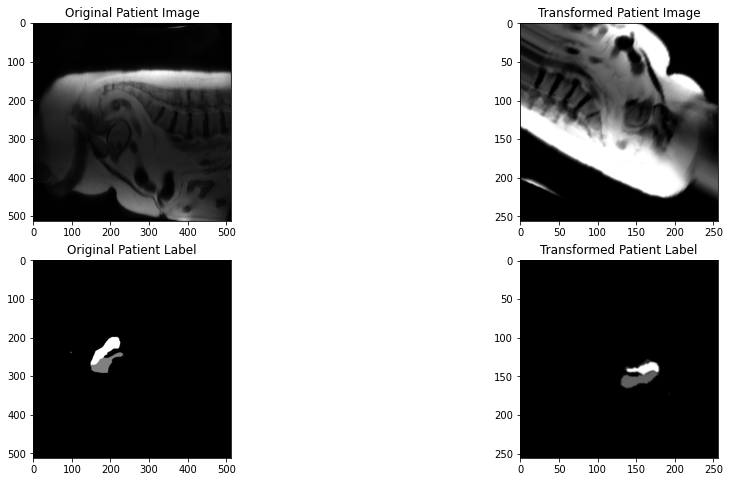

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(2,2,1)
plt.title("Original Patient Image")
plt.imshow(sample_patient_og['image'][1,0,3,:,:], cmap="gray")
plt.subplot(2,2,2)
plt.title("Transformed Patient Image")
plt.imshow(sample_patient['image'][1,0,3,:,:], cmap="gray")
plt.subplot(2,2,3)
plt.title("Original Patient Label")
plt.imshow(sample_patient_og['label'][1,0,3,:,:], cmap="gray")
plt.subplot(2,2,4)
plt.title("Transformed Patient Label")
plt.imshow(sample_patient['label'][1,0,3,:,:], cmap="gray")

#Model Developement

In [ ]:
model = UNet(
    spatial_dims=3,
    in_channels=7,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(1, 1, 1, 1),
    num_res_units=2,
    norm = Norm.BATCH
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
dice_metric = DiceMetric(include_background=True, reduction="mean")
scaler = torch.cuda.amp.GradScaler()
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")


In [ ]:
# random_output = model(sample_patient_og['image'])
print(f"Image shape:{sample_patient['image'].shape}")
print(f"Label shape:{sample_patient['label'].shape}")
# print(f"Random prediction shape:{random_output.shape}")

Image shape:(2, 7, 256, 256)
Label shape:(2, 7, 256, 256)


In [ ]:
def train(model, train_loader, test_loader, loss, optim, max_epochs, model_dir, device = device):
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
    best_metric = -1
    best_metric_epoch = -1
    best_metrics_epochs_and_time = [[], [], []]
    epoch_loss_values = []
    metric_values = []

    total_start = time.time()
    for epoch in range(max_epochs):
        epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                print(f"output shape: {outputs.shape}",
                      f"labels shape: {labels.shape}")
                loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()
            print(
                f"{step}/{len(train_dataset) // train_loader.batch_size}"
                f", train_loss: {loss.item():.4f}"
                f", step time: {(time.time() - step_start):.4f}"
            )
        lr_scheduler.step()
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        np.save(os.path.join(model_dir, 'epoch_loss_values.npy'), epoch_loss_values)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % 1 == 0:
            model.eval()
            with torch.inference_mode():

                for val_data in test_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    val_outputs = model(val_inputs)
                    dice_metric(y_pred=val_outputs, y=val_labels)
                    dice_metric_batch(y_pred=val_outputs, y=val_labels)

                metric = dice_metric.aggregate().item()
                metric_values.append(metric)
                np.save(os.path.join(model_dir, 'metric_values.npy'), metric_values)
                metric_batch = dice_metric_batch.aggregate()

                dice_metric.reset()
                dice_metric_batch.reset()

                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    best_metrics_epochs_and_time[0].append(best_metric)
                    best_metrics_epochs_and_time[1].append(best_metric_epoch)
                    best_metrics_epochs_and_time[2].append(time.time() - total_start)
                    torch.save(
                        model.state_dict(),
                        os.path.join(model_dir, "best_metric_model.pth"),
                    )
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )
        print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
    total_time = time.time() - total_start

In [ ]:
model_dir = '/content/drive/MyDrive/Projects/MR-loc Segmentation/Results'
train(model,train_loader, test_loader, loss_function, optimizer, 10, model_dir)

----------
epoch 1/10


RuntimeError: ignored

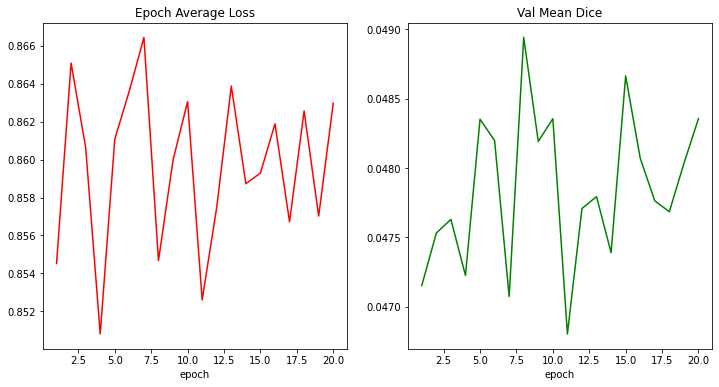

In [ ]:
epoch_loss_values = np.load(os.path.join(model_dir, "epoch_loss_values.npy"))
metric_values = np.load(os.path.join(model_dir, "metric_values.npy"))


plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [1 * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()